In [53]:
!pip install lightning

In [54]:
import os
import torch
import torch.nn.functional as F
import lightning as L
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split, Subset
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

In [55]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Sequential(nn.Linear(28*28, 64), 
                                nn.ReLU(),
                                nn.Linear(64, 3))

    def forward(self, x):
        return self.l1(x)

class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Sequential(nn.Linear(3, 64), nn.ReLU(), nn.Linear(64, 28*28))

    def forward(self, x):
        return self.l1(x)

In [56]:
# Repeated code - why?
class BasicAutoEncoder(L.LightningModule):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def training_step(self, batch, batch_idx):
        x, _ = batch
        
        # Flatten
        x = x.view(x.size(0), -1)

        z = self.encoder(x)
        x_hat = self.decoder(z)
        loss = F.mse_loss(x_hat, x)

        return loss

    def validation_step(self, batch, batch_idx):
        x, _ = batch
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        x_hat = self.decoder(z)
        val_loss = F.mse_loss(x_hat, x)
        self.log("val_loss", val_loss)
        

    def test_step(self, batch, batch_idx):
        x, _ = batch
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        x_hat = self.decoder(z)
        test_loss = F.mse_loss(x_hat, x)
        self.log("test_loss", test_loss)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [57]:
transform = transforms.ToTensor()
train_set = MNIST(root="MNIST", download=True, train=True, transform=transform)
test_set = MNIST(root="MNIST", download=True, train=False, transform=transform)

In [58]:
# train-val split
train_set_size = int(len(train_set) * 0.8)
valid_set_size = len(train_set) - train_set_size

seed = torch.Generator().manual_seed(42)
train_set, valid_set = random_split(train_set, [train_set_size, valid_set_size], generator = seed)

data_sets = [train_set, valid_set, test_set]

48000


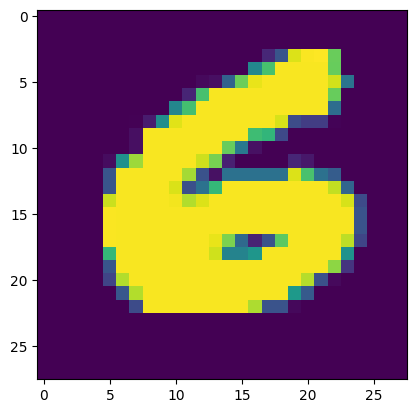

In [59]:
print(len(train_set))
# print(train_set[0])
plt.imshow(train_set[0][0][0])

In [60]:
# Init data loaders
init_loader = lambda x: DataLoader(x, num_workers=4, pin_memory=True)
train_loader, valid_loader, test_loader = [init_loader(x) for x in data_sets]

In [61]:
autoencoder = BasicAutoEncoder(Encoder(), Decoder())

trainer = L.Trainer(max_epochs=5, callbacks=[EarlyStopping(monitor="val_loss", mode="min")], limit_train_batches=0.01, limit_val_batches=0.01, profiler="simple")
trainer.fit(autoencoder, train_loader, valid_loader)

INFO: GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: 
  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | encoder | Encoder | 50.4 K | train
1 | decoder | Decoder | 51.2 K | train
--------------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.407     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO: FIT Profiler Report

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                       

In [62]:
os.cpu_count()

4

In [63]:
trainer.test(autoencoder, dataloaders=test_loader)

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.04988054186105728    │
└───────────────────────────┴───────────────────────────┘

INFO: TEST Profiler Report

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                          	|  -              	|  270736    

[{'test_loss': 0.04988054186105728}]

In [75]:
%reload_ext tensorboard
%tensorboard --logdir=lightning_logs/

<IPython.core.display.Javascript object>

In [74]:
!kill 2520

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [66]:
%tensorboard --logdir=lightning_logs/

Reusing TensorBoard on port 6006 (pid 2520), started 0:00:01 ago. (Use '!kill 2520' to kill it.)

<IPython.core.display.Javascript object>

In [67]:
from tensorboard import notebook
notebook.list()

Known TensorBoard instances:
  - port 6006: logdir lightning_logs/ (started 0:01:06 ago; pid 2520)


In [69]:
notebook.display(port=6006, height=1000)

Selecting TensorBoard with logdir lightning_logs/ (started 0:01:25 ago; port 6006, pid 2520).


<IPython.core.display.Javascript object>